In [6]:
!pip install mir_eval
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [7]:
from Datasets.Audiodata import *
from Models.UNet import *
from Models.UNet2 import *

from torch.utils.data import random_split
from torchsummary import summary
import matplotlib.pyplot as plt
import mir_eval
import pandas as pd
import numpy as np

import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [10]:
# import zipfile
# from tqdm import tqdm

# zip_path = "Data/train.zip"
# extract_path = "Data/"

# with zipfile.ZipFile(zip_path, 'r') as z:
#     for file in tqdm(z.namelist(), desc="Extracting files"):
#         z.extract(file, extract_path)

In [11]:
dataset = Audiodataset(set='train_small')
print(len(dataset))

50


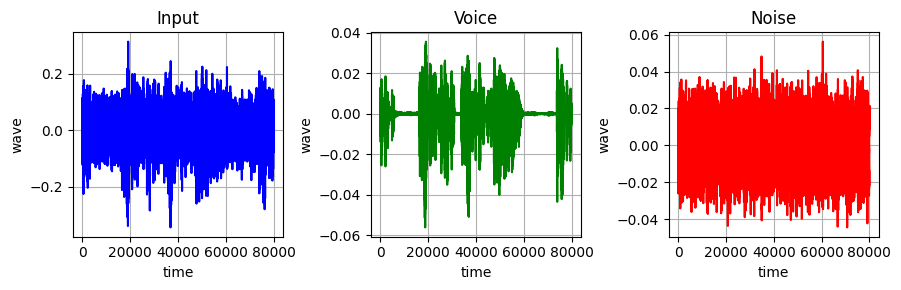

In [12]:
dataset.take_wave()
dataset.plot(0)

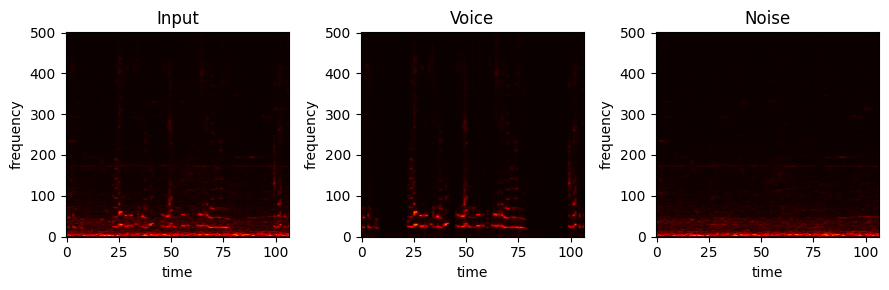

In [13]:
dataset.take_spectrogram()
dataset.plot(0)
plt.savefig('Figs/sp.png')

In [14]:
idx = 2
sr = 8000

test_dataset = Audiodataset('test', padding=True)
test_dataset.return_only_voice()
test_dataset.take_spectrogram()
X, VoiceSP = test_dataset[idx]

reconstruct = test_dataset.reconstruct(VoiceSP, idx, reference='voice')
print(reconstruct.shape)
IPython.display.Audio(reconstruct.squeeze().numpy(), rate=sr)

torch.Size([1, 80000])


In [15]:
model = UNet().to(device)

summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

In [16]:
voice_train_dataset = Audiodataset('train',padding = True,  getitem='voice')
voice_train_dataset.take_spectrogram()

voice_test_dataset = Audiodataset('test', padding = True,getitem='voice')
voice_test_dataset.take_spectrogram()

In [17]:
#voice_model, voice_losses = UNet.trainModel(voice_train_dataset, data_type='Voice', n_epochs=20, batch_size=16, learning_rate=0.001, valid_dataset=voice_test_dataset)

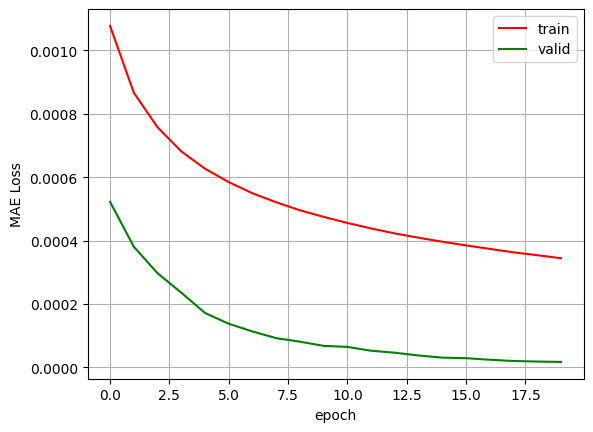

In [18]:
voice_scores_UNet = pd.read_csv('Scores/UNet/Voice/UNetMAE.csv')
voice_train_error = voice_scores_UNet['train']
voice_valid_error = voice_scores_UNet['valid']
plt.plot(voice_train_error, color='red', label='train')
plt.plot(voice_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_voice_loss.png')

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
voice_model = UNet().to(device)

# Ensure that the map_location is set to CPU if CUDA is not available
voice_model.load_state_dict(torch.load('Paths/UNet/Voice/model_40.pth', map_location=device))

<All keys matched successfully>

In [20]:
idx = 2
X, Y = voice_test_dataset[idx]
output = voice_model(X.unsqueeze(0).unsqueeze(0).to(device))

(512, 128) (512, 128)


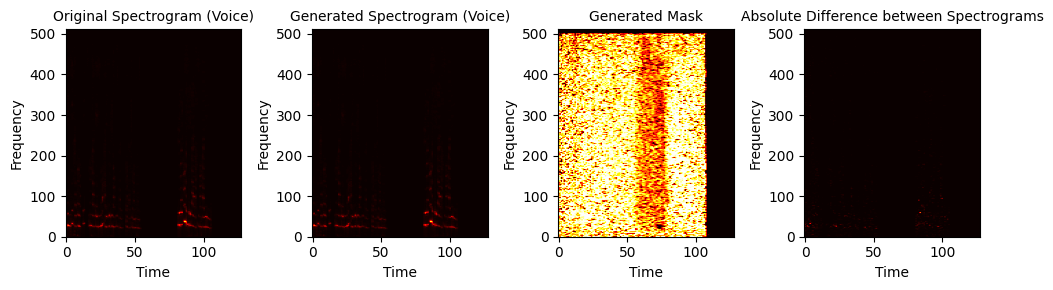

In [21]:
Y_ = Y.unsqueeze(0).unsqueeze(0).to(device)
pred = output * Y_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Voice)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_voice_sp.png')
plt.show()


In [22]:
np.sum(np.abs(Vtrue-Vpred))

21.606464

In [26]:
reconstructed_true = voice_test_dataset.reconstruct(Y, id0=idx, reference = 'voice')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [27]:
reconstructed_output = voice_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='voice')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

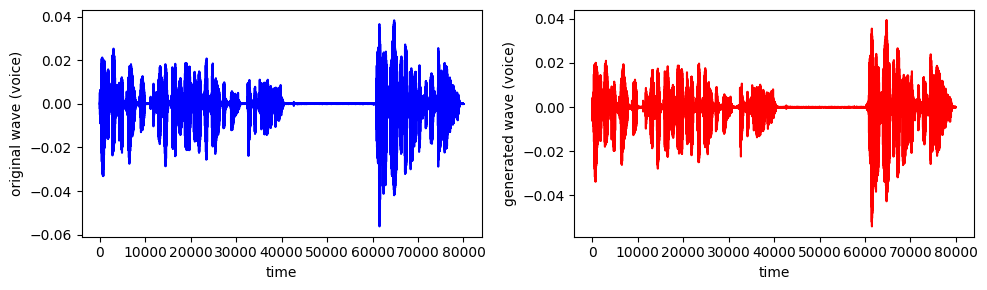

In [28]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')
plt.savefig('Figs/UNet_voice_wave.png')

plt.tight_layout()

In [29]:
noise_train_dataset = Audiodataset('train',padding = True,  getitem='noise')
noise_train_dataset.take_spectrogram()

noise_test_dataset = Audiodataset('test', padding = True,getitem='noise')
noise_test_dataset.take_spectrogram()

In [30]:
#noise_model, noise_losses = UNet.trainModel(noise_train_dataset, data_type='Noise', n_epochs=20, batch_size=16, learning_rate=0.001, valid_dataset=noise_test_dataset)

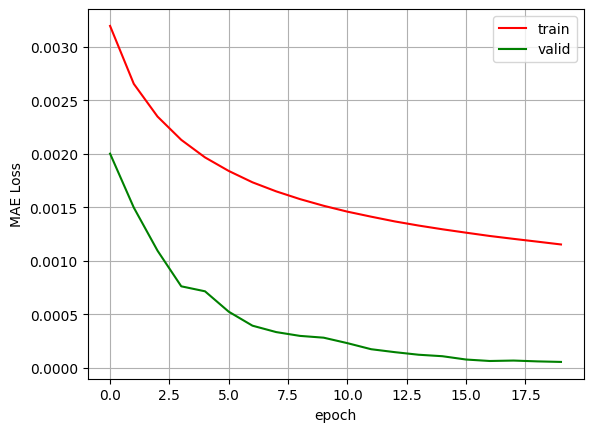

In [31]:
noise_scores_UNet = pd.read_csv('Scores/UNet/Noise/UNetMAE.csv')
noise_train_error = noise_scores_UNet['train']
noise_valid_error = noise_scores_UNet['valid']
plt.plot(noise_train_error, color='red', label='train')
plt.plot(noise_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet_noise_loss.png')

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
noise_model = UNet().to(device)

# Ensure that the map_location is set to CPU if CUDA is not available
noise_model.load_state_dict(torch.load('Paths/UNet/Noise/model_20.pth', map_location=device))

<All keys matched successfully>

In [39]:
idx = 2
X, Y = noise_test_dataset[idx]
output = noise_model(X.unsqueeze(0).unsqueeze(0).to(device))

(512, 128) (512, 128)


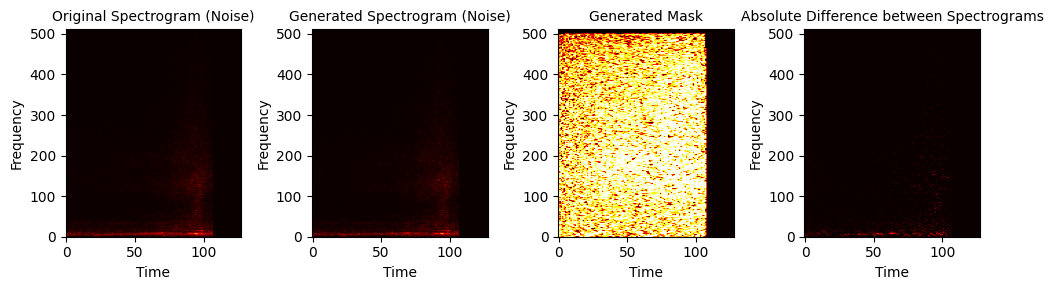

In [40]:
Y_ = Y.unsqueeze(0).unsqueeze(0).to(device)
pred = output * Y_

Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()

print(Vpred.shape, Vtrue.shape)

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Noise)', fontsize=10)  # Reduce title size
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

axs[2].imshow(mask, aspect='auto', origin='lower', cmap='hot')
axs[2].set_title('Generated Mask', fontsize=10)  # Reduce title size
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')

axs[3].imshow(np.abs(Vpred - Vtrue), aspect='auto', origin='lower', cmap='hot')
axs[3].set_title('Absolute Difference between Spectrograms', fontsize=10)  # Reduce title size
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('Figs/UNet_noise_sp.png')

plt.show()


In [41]:
np.sum(np.abs(Vtrue-Vpred))

63.02879

In [42]:
reconstructed_true = noise_test_dataset.reconstruct(Y, id0=idx, reference = 'noise')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

In [43]:
reconstructed_output = noise_test_dataset.reconstruct(pred.cpu(), id0=idx, reference='noise')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

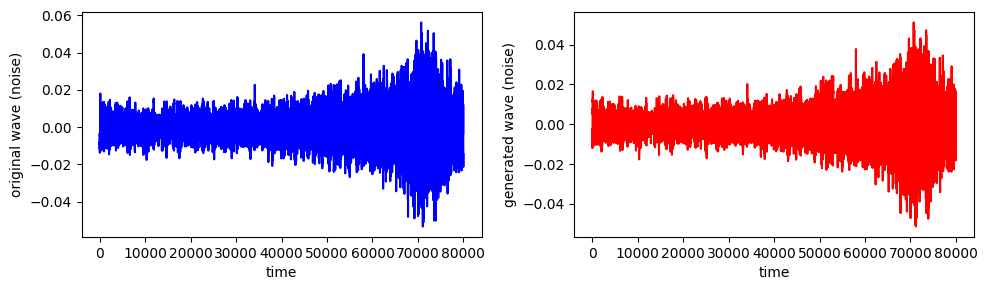

In [44]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (noise)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (noise)')
plt.savefig('Figs/UNet_noise_wave.png')

plt.tight_layout()

In [45]:
test_dataset = Audiodataset('test',padding = True,  getitem='all')
test_dataset.take_spectrogram()

In [ ]:
metrics_data = UNet.validateModel(voice_model, noise_model, test_dataset,subset_size=400)

Validation Progress: 100%|██████████| 400/400 [07:42<00:00,  1.16s/it]


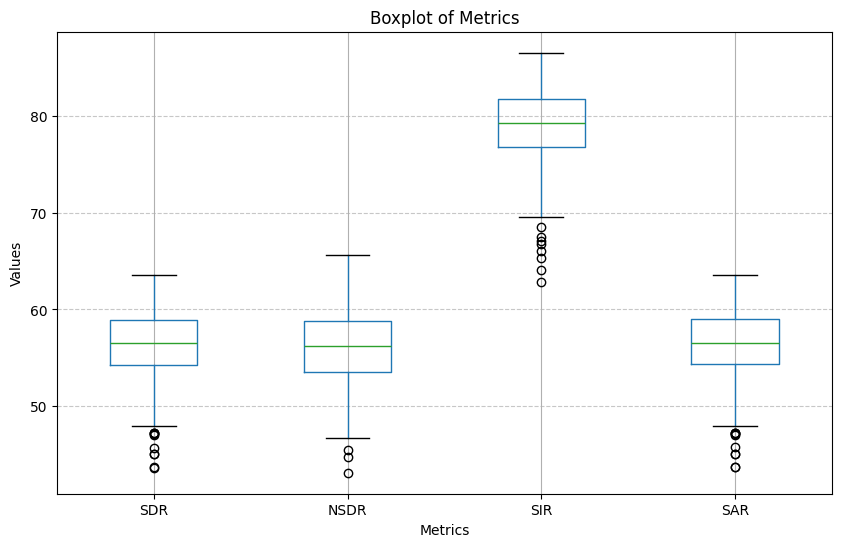

In [48]:
plt.figure(figsize=(10, 6))
metrics_data = pd.read_csv('Scores/UNet/val_metrics.csv')
metrics_data.boxplot(column=['SDR', 'NSDR', 'SIR', 'SAR'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Boxplot of Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Save the plot
plt.savefig('Figs/UNet_val_metrics.png')
# Show the plot
plt.show()




In [50]:
model2 = UNet2().to(device)
from torchsummary import summary
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

In [51]:
train_dataset = Audiodataset('train',padding = True,  getitem='all')
train_dataset.take_spectrogram()

test_dataset = Audiodataset('test', padding = True,getitem='all')
test_dataset.take_spectrogram()

In [52]:
#model2, losses2 = UNet2.trainModel(train_dataset, n_epochs=20, batch_size=16, learning_rate=0.001, valid_dataset=test_dataset)

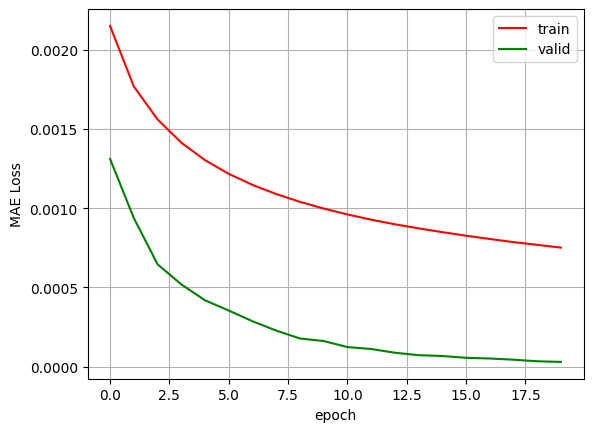

In [53]:
scores_UNet2 = pd.read_csv('Scores/UNet2/UNet2MAE.csv')
train_error = scores_UNet2['train']
valid_error = scores_UNet2['valid']
plt.plot(train_error, color='red', label='train')
plt.plot(valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/UNet2_loss.png')

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = UNet2().to(device)

# Ensure that the map_location is set to CPU if CUDA is not available
model2.load_state_dict(torch.load('Paths/UNet2/model_20.pth', map_location=device))

<All keys matched successfully>

In [55]:
idx = 2
X, voice,noise,_,_ = test_dataset[idx]
output = model2(X.unsqueeze(0).unsqueeze(0).to(device)).squeeze()
voice_ = voice.unsqueeze(0)
noise_ = noise.unsqueeze(0)
Y = torch.cat((voice_, noise_), dim=0).to(device)  # Concatenate along the channel dimension

In [56]:
pred = output * Y

Vpred = (pred).squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
mask = output.squeeze().detach().cpu().numpy()
voice_ = voice_.squeeze().detach().cpu().numpy()
noise_ = noise_.squeeze().detach().cpu().numpy()
print(Vpred.shape, mask.shape)

(2, 512, 128) (2, 512, 128)


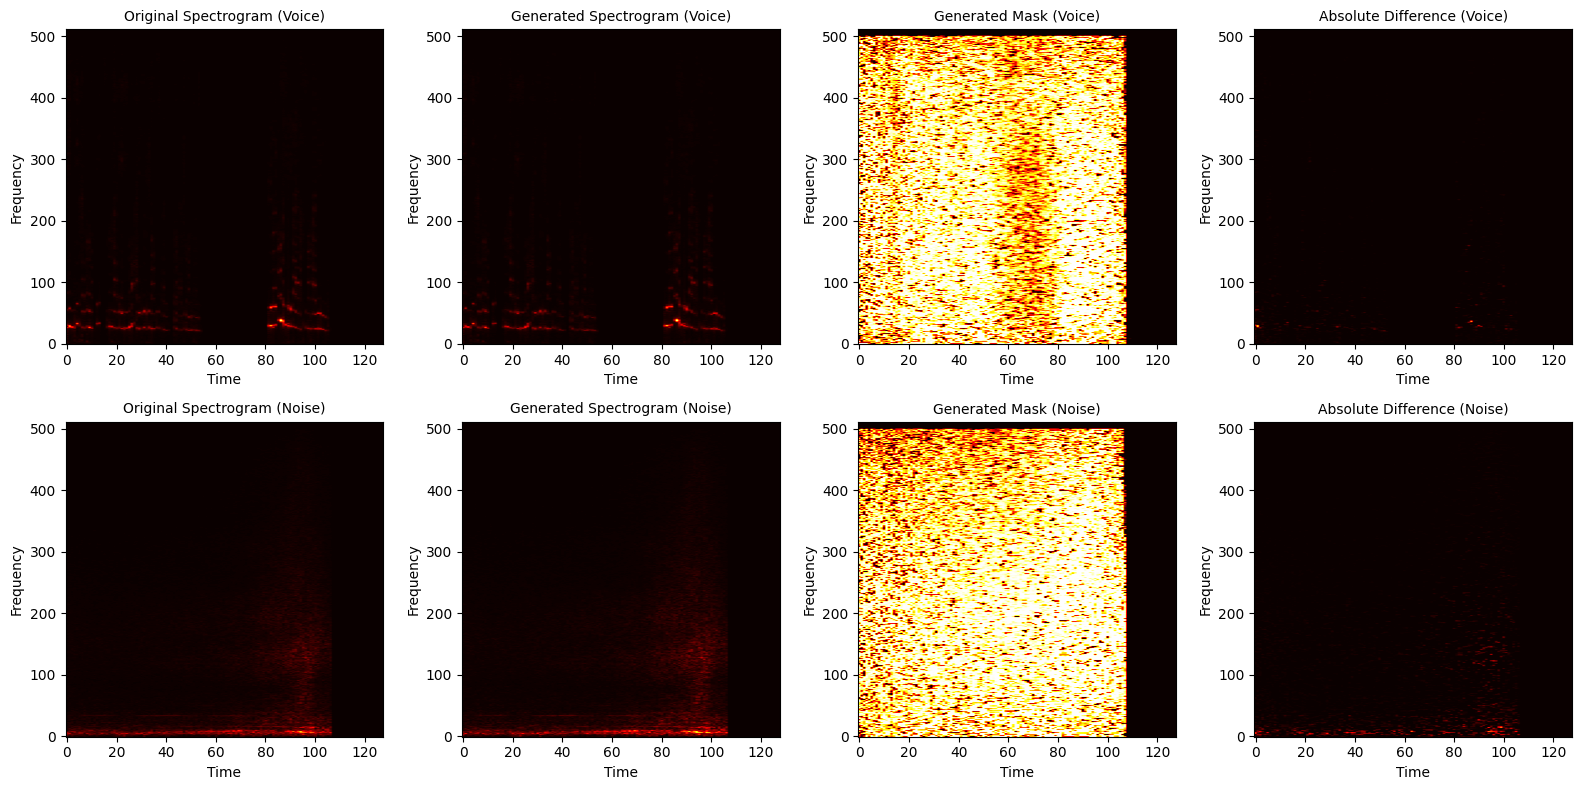

In [57]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 lignes, 4 colonnes, taille ajustée

# Ligne 1 : Voice
# Original Spectrogram (Voice)
axs[0, 0].imshow(voice_, aspect='auto', origin='lower', cmap='hot')
axs[0, 0].set_title('Original Spectrogram (Voice)', fontsize=10)
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Frequency')

# Generated Spectrogram (Voice)
axs[0, 1].imshow(Vpred[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 1].set_title('Generated Spectrogram (Voice)', fontsize=10)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Frequency')

# Generated Mask (Voice)
axs[0, 2].imshow(mask[0], aspect='auto', origin='lower', cmap='hot')
axs[0, 2].set_title('Generated Mask (Voice)', fontsize=10)
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Frequency')

# Absolute Difference (Voice)
axs[0, 3].imshow(np.abs(Vpred[0] - voice_), aspect='auto', origin='lower', cmap='hot')
axs[0, 3].set_title('Absolute Difference (Voice)', fontsize=10)
axs[0, 3].set_xlabel('Time')
axs[0, 3].set_ylabel('Frequency')

# Ligne 2 : Noise
# Original Spectrogram (Noise)
axs[1, 0].imshow(noise_, aspect='auto', origin='lower', cmap='hot')
axs[1, 0].set_title('Original Spectrogram (Noise)', fontsize=10)
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Frequency')

# Generated Spectrogram (Noise)
axs[1, 1].imshow(Vpred[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 1].set_title('Generated Spectrogram (Noise)', fontsize=10)
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Frequency')

# Generated Mask (Noise)
axs[1, 2].imshow(mask[1], aspect='auto', origin='lower', cmap='hot')
axs[1, 2].set_title('Generated Mask (Noise)', fontsize=10)
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Frequency')

# Absolute Difference (Noise)
axs[1, 3].imshow(np.abs(Vpred[1] - noise_), aspect='auto', origin='lower', cmap='hot')
axs[1, 3].set_title('Absolute Difference (Noise)', fontsize=10)
axs[1, 3].set_xlabel('Time')
axs[1, 3].set_ylabel('Frequency')

# Ajustements finaux
plt.tight_layout()  # Ajuste les espacements pour éviter les chevauchements
plt.savefig('Figs/UNet2_sp.png')  # Enregistre la figure
plt.show()  # Affiche la figure


In [58]:
print(np.sum(np.abs(Vpred[0] - voice_)),np.sum(np.abs(Vpred[1] - noise_)))

21.904587 63.837517


In [59]:
voice_gt = test_dataset.reconstruct(voice, id0=idx, reference = 'voice')
IPython.display.Audio(voice_gt.detach().numpy(), rate=8000)

In [60]:
voice_est = (pred).squeeze().detach().cpu()[0]
voice_est = test_dataset.reconstruct(voice_est, id0=idx, reference = 'voice')
IPython.display.Audio(voice_est.detach().numpy(), rate=8000)

In [61]:
noise_gt = test_dataset.reconstruct(noise, id0=idx, reference = 'noise')
IPython.display.Audio(noise_gt.numpy(), rate=8000)

In [62]:
noise_est = (pred).squeeze().detach().cpu()[1]
noise_est = test_dataset.reconstruct(noise_est, id0=idx, reference = 'noise')
IPython.display.Audio(noise_est.numpy(), rate=8000)

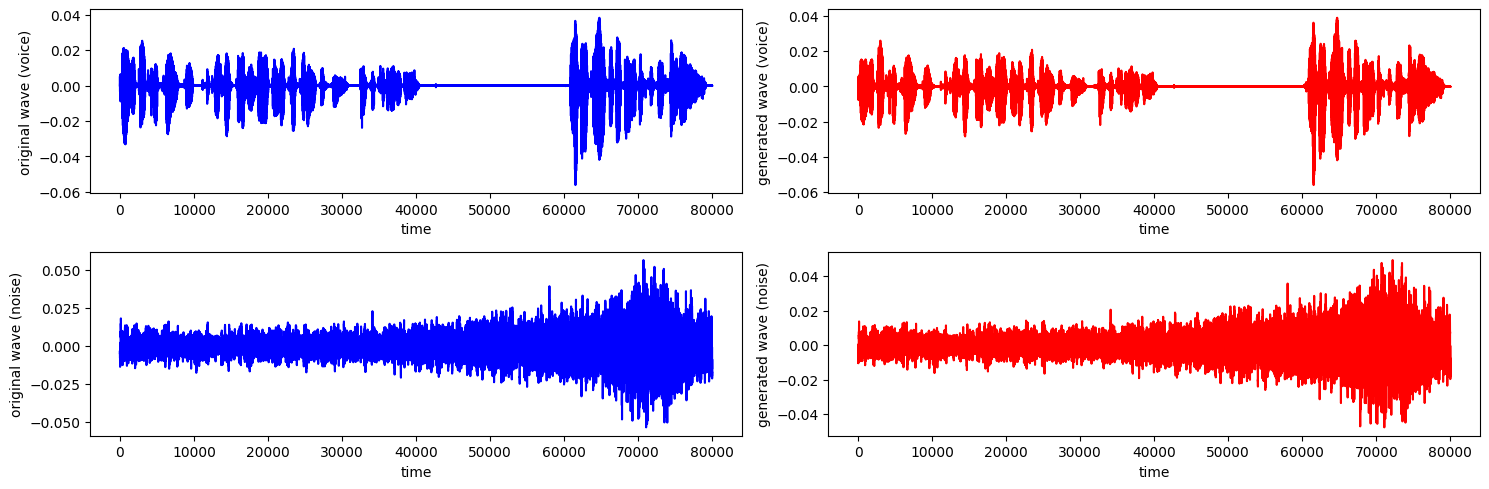

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0,0].plot(voice_gt.squeeze().numpy(), color='blue')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('original wave (voice)')

axs[0,1].plot(voice_est.squeeze().numpy(), color='red')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('generated wave (voice)')


axs[1,0].plot(noise_gt.squeeze().numpy(), color='blue')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('original wave (noise)')

axs[1,1].plot(noise_est.squeeze().numpy(), color='red')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('generated wave (noise)')
plt.savefig('Figs/UNet2_wave.png')
plt.tight_layout()

In [ ]:
metrics_data2 = UNet2.validateModel(model2, test_dataset,subset_size=400)

Validation Progress: 100%|██████████| 400/400 [07:37<00:00,  1.14s/it]


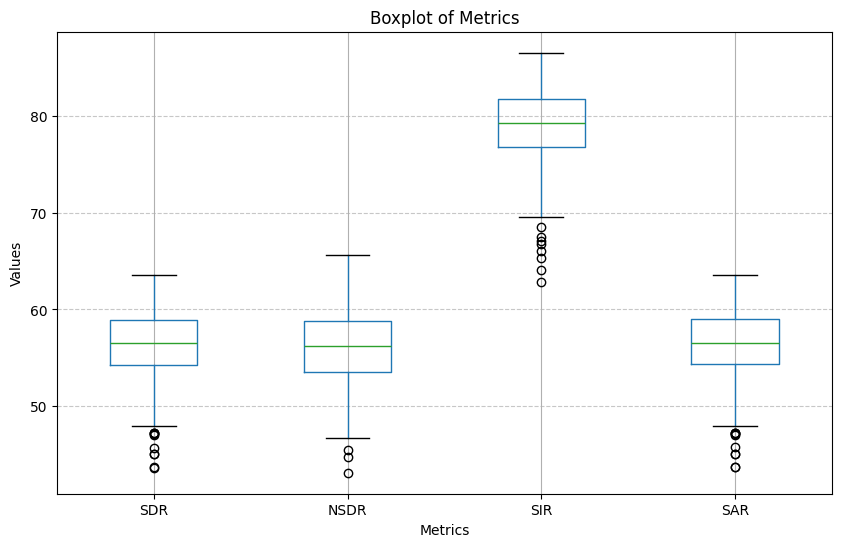

In [68]:
plt.figure(figsize=(10, 6))
metrics_data2 = pd.read_csv('Scores/UNet2/val_metrics.csv')
metrics_data2.boxplot(column=['SDR', 'NSDR', 'SIR', 'SAR'])

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Boxplot of Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Save the plot
plt.savefig('Figs/UNet2_val_metrics.png')
# Show the plot
plt.show()


